In [77]:
import tensorflow as tf
import keras
import os
import numpy as np 
import pandas as pd
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import clear_output as cls

In [78]:
root_path = '/kaggle/input/animal-image-classification-dataset/Training Data/Training Data/'
class_names = ['Cat','Cow','Dog','Elephant', 'Gorilla', 'Hippo', 'Monkey', 'Panda', 'Tiger', 'Zebra']
n_classes = len(class_names)

class_dis = [len(os.listdir(root_path + name)) for name in class_names]

print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 10 
Class Names : ['Cat', 'Cow', 'Dog', 'Elephant', 'Gorilla', 'Hippo', 'Monkey', 'Panda', 'Tiger', 'Zebra']


In [79]:
fig = px.pie(names=class_names, values=class_dis, title="Training Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [80]:
valid_path = '/kaggle/input/animal-image-classification-dataset/Validation Data/Validation Data/'

class_dis = [len(os.listdir(valid_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Validation Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [81]:
test_path = '/kaggle/input/animal-image-classification-dataset/Testing Data/Testing Data/'

class_dis = [len(os.listdir(test_path + name)) for name in class_names]

fig = px.pie(names=class_names, values=class_dis, title="Testing Class Distribution", color=class_names, hole=0.2)
fig.update_layout({'title':{'x':0.48}})
fig.show()

In [82]:
train_gen = ImageDataGenerator(rescale=1/255., rotation_range=10, horizontal_flip=True)
valid_gen = ImageDataGenerator(rescale=1/255.)
test_gen = ImageDataGenerator(rescale=1/255)

train_ds = train_gen.flow_from_directory(root_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
valid_ds = valid_gen.flow_from_directory(valid_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names) 
test_ds = test_gen.flow_from_directory(test_path, class_mode='categorical', target_size=(224,224), shuffle=True, batch_size=32, classes = class_names)

Found 20000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1907 images belonging to 10 classes.


In [83]:
def plot_learning_curves(history, lr):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss'+" Lr = "+lr)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy'+" Lr = "+lr)
    plt.legend()

    plt.tight_layout()
    plt.show()

In [84]:
def show_images(GRID=[5,5], model=None, size=(20,20), data=train_ds):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_cols * n_rows
    
    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[np.argmax(labels[id])]
        
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        
        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()
            
        plt.title(title)
        plt.axis('off')
        
        i+=1
        if i>=(n_images+1):
            break
            
    plt.tight_layout()
    plt.show()

Epoch 1/15
625/625 [==============================] - 318s 456ms/step - loss: 1.7987 - accuracy: 0.3898 - val_loss: 2.0065 - val_accuracy: 0.4080
Epoch 2/15
625/625 [==============================] - 275s 440ms/step - loss: 1.3253 - accuracy: 0.5486 - val_loss: 4.5354 - val_accuracy: 0.1960
Epoch 3/15
625/625 [==============================] - 273s 436ms/step - loss: 1.1196 - accuracy: 0.6170 - val_loss: 1.4252 - val_accuracy: 0.5310
Epoch 4/15
625/625 [==============================] - 273s 436ms/step - loss: 1.0000 - accuracy: 0.6621 - val_loss: 2.2040 - val_accuracy: 0.5240
Epoch 5/15
625/625 [==============================] - 274s 439ms/step - loss: 0.9012 - accuracy: 0.7032 - val_loss: 1.2141 - val_accuracy: 0.5830
Epoch 6/15
625/625 [==============================] - 273s 436ms/step - loss: 0.8190 - accuracy: 0.7339 - val_loss: 1.3294 - val_accuracy: 0.6050
Epoch 7/15
625/625 [==============================] - 273s 437ms/step - loss: 0.7673 - accuracy: 0.7494 - val_loss: 1.8463 -

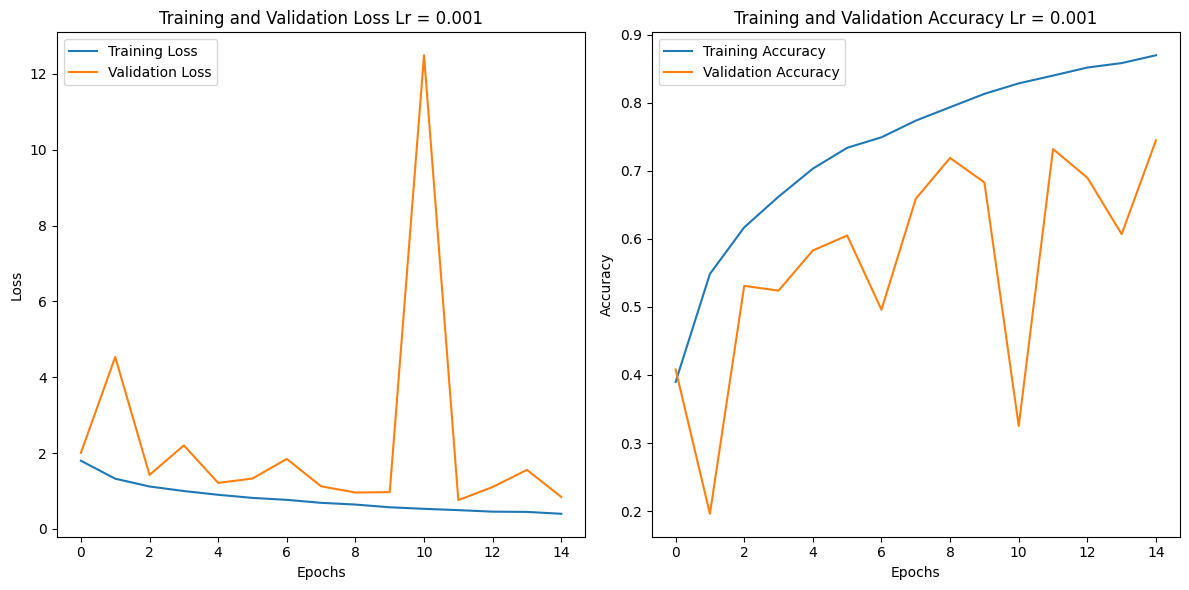

In [85]:
model_resnet50 = tf.keras.applications.resnet50.ResNet50(include_top=True,weights = None, classes=10, classifier_activation='softmax')
epochs = 15
model_resnet50.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_checkpoint_callback  = tf.keras.callbacks.ModelCheckpoint(
        "/kaggle/working/resnet50_checkpoints/",
    monitor= 'val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode="max",
    save_freq='epoch',
)

history_resnet50 = model_resnet50.fit(
    train_ds,
    epochs=epochs,
    callbacks=[model_checkpoint_callback],
    validation_data=valid_ds,
    verbose=1
)
plot_learning_curves(history_resnet50, "0.001")

In [86]:
model = history_resnet50.model

In [87]:
loss_val, accuracy = model.evaluate(test_ds)
print("Loss value = ", loss_val)
print("accuracy = ", accuracy)

60/60 [==============================] - 7s 122ms/step - loss: 0.8229 - accuracy: 0.7567
Loss value =  0.8228862285614014
accuracy =  0.7566859126091003


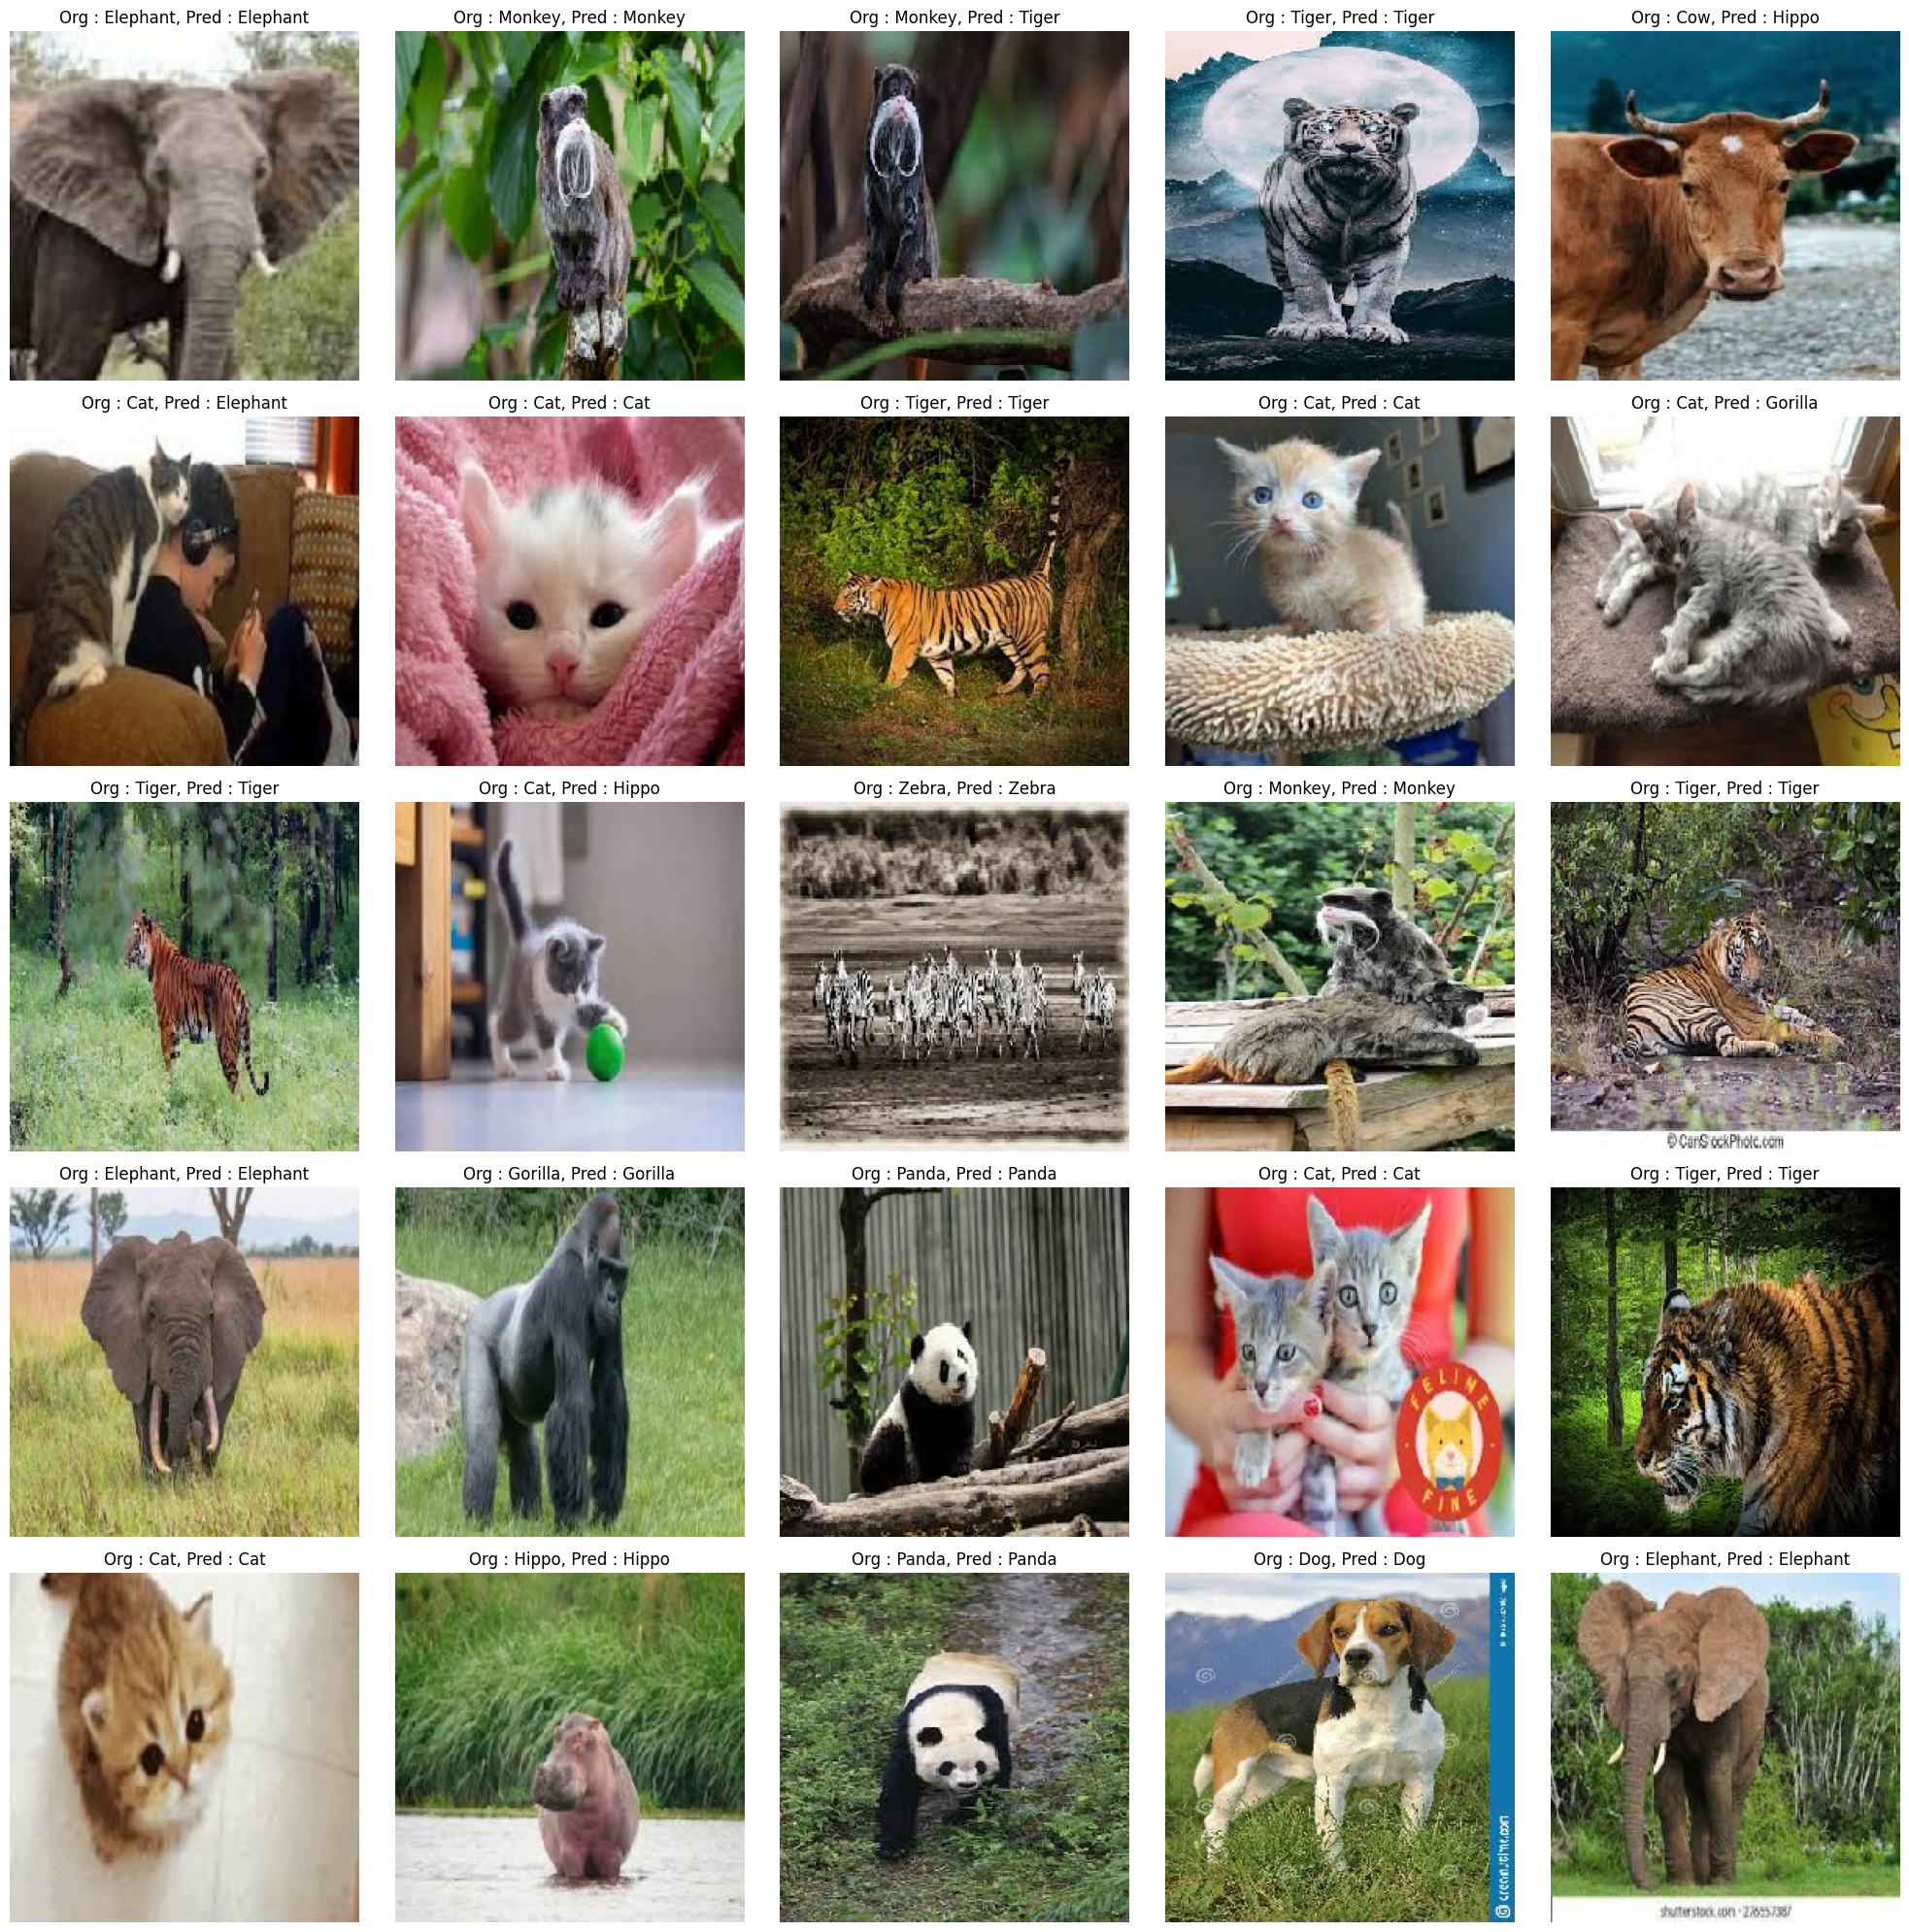

In [88]:
show_images(model=model, data=test_ds)

In [89]:
from sklearn.metrics import f1_score, classification_report

def calculate_f1_score_batch(model, images, labels):
    y_true = np.argmax(labels, axis=1)
    y_pred = np.argmax(model.predict(images), axis=1)

    f1_scores = f1_score(y_true, y_pred, average=None)
    avg_f1_score = f1_score(y_true, y_pred, average='weighted')  
    return f1_scores, avg_f1_score


1/1 [==============================] - 0s 31ms/step
F1 Scores for Model 1 (one batch): [0.5        0.72727273 0.28571429 1.         0.85714286 0.8
 0.75       1.         0.25       0.75      ]
Average F1 Score for Model 1 (one batch): 0.6752029220779221


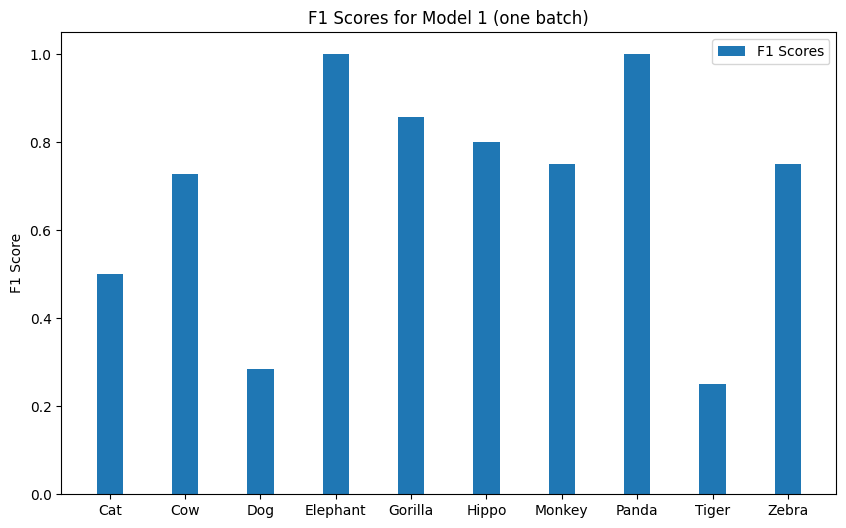

In [98]:
images_batch, labels_batch = next(iter(valid_ds))

f1_scores_batch, avg_f1_batch = calculate_f1_score_batch(model, images_batch, labels_batch)

print("F1 Scores for Model 1 (one batch):", f1_scores_batch)
print("Average F1 Score for Model 1 (one batch):", avg_f1_batch)

def plot_f1_scores_bar(f1_scores, class_names, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.35
    ind = np.arange(len(class_names))

    rects1 = ax.bar(ind, f1_scores, width, label='F1 Scores')

    ax.set_xticks(ind)
    ax.set_xticklabels(class_names)
    ax.legend()

    ax.set_ylabel('F1 Score')
    ax.set_title(title)

    plt.show()

plot_f1_scores_bar(f1_scores_batch, class_names, 'F1 Scores for Model 1 (one batch)')


In [91]:
model.save("ResNet_10.h5")
model.save("ResNet_10.keras")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

